In [1]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated,Literal
import os
from langchain_google_genai import ChatGoogleGenerativeAI  
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,SystemMessage

In [2]:
load_dotenv()

True

In [6]:
def create_llm(model):
    api_key=os.getenv("GOOGLE_API_KEY")

    llm=ChatGoogleGenerativeAI(model=model,
                               api_key=api_key)
    
    return llm

In [8]:
generator_llm=create_llm(model="gemini-1.5-flash")
evaluator_llm=create_llm(model="gemini-2.5-flash")
optimizer_llm=create_llm(model="gemini-2.5-flash")

In [21]:
class TweetState(TypedDict):

    topic:str
    tweet:str
    evaluation:Literal['approved','need improvement']
    feedback:str
    iteration:int
    max_iteration:int


In [24]:
class evalschema(BaseModel):

    evaluation:Literal['approved','need_improvement']=Field(description="evaluation of the tweet")
    feedback:str=Field(description="feedback for improving the tweet")

In [12]:
stuctured_evaluator_llm=evaluator_llm.with_structured_output(evalschema)

In [14]:
def generate_tweet(state:TweetState):

    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    response=generator_llm.invoke(messages).content

    return {'tweet':response}



In [15]:
def evaluate_tweet(state:TweetState):
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    response=stuctured_evaluator_llm.invoke(messages).content

    return {'evaluation':response.evaluation,'feedback':response.feedback}


In [17]:
def optimize_tweet(state:TweetState):
     messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
     response=optimizer_llm.invoke(messages).content
     iteration=state['iteration']+1

     return {'tweet':response,
             'iteration':iteration}

In [33]:
def condition(state:TweetState):
    if state['evaluation']=='approved' or state['iteration']>=state['max_iteration']:
        return 'approved'
    else:
        return 'need_improvement'

In [35]:
graph=StateGraph(TweetState)

graph.add_node('generate_tweet',generate_tweet)
graph.add_node('evaluate_tweet',evaluate_tweet)
graph.add_node('optimize_tweet',optimize_tweet)
# graph.add_node('approved',approved)

graph.add_edge(START,'generate_tweet')
graph.add_edge('generate_tweet','evaluate_tweet')
graph.add_conditional_edges('evaluate_tweet',condition,{'approved':END,"need_improvement":'optimize_tweet'})
graph.add_edge('optimize_tweet','evaluate_tweet')

workflow=graph.compile()

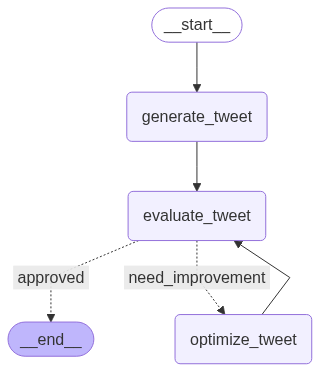

In [36]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass
